In [1]:
import pandas as pd

In [2]:
#load dataset
df = pd.read_csv('data_set/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
#filter dataset, consider only the "store=1" and its' "item=1"
df = df[df['store'] == 1]
df = df[df['item'] == 1]

In [4]:
#drop store
df.drop('store', axis=1, inplace=True)
#drop item
df.drop('item', axis=1, inplace=True)

In [5]:
#convert 'date' property to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [6]:
#split dataset to build models
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

## SARIMA Model

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Step 1 - Check stationary

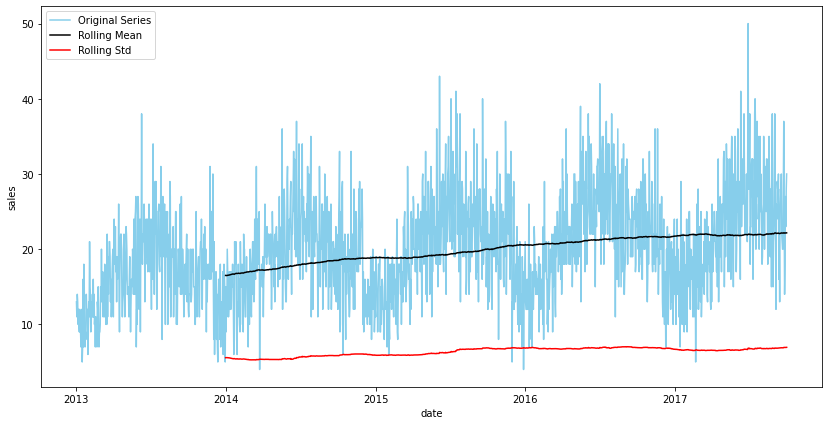

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


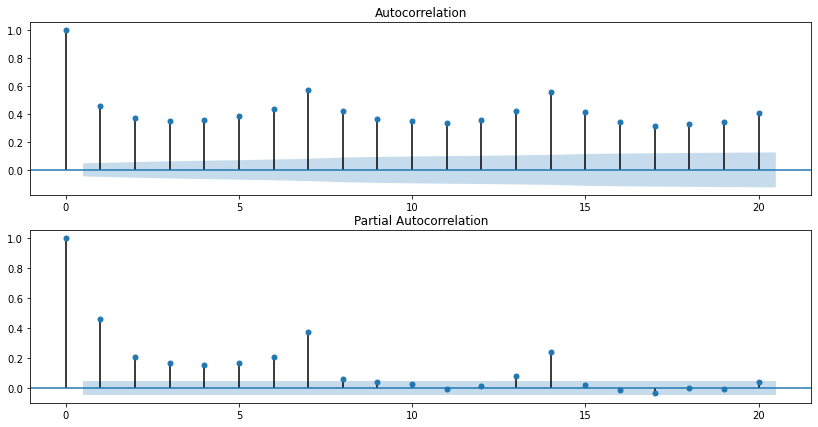

In [13]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

Data is not staionary.

### Step 2 - differencing

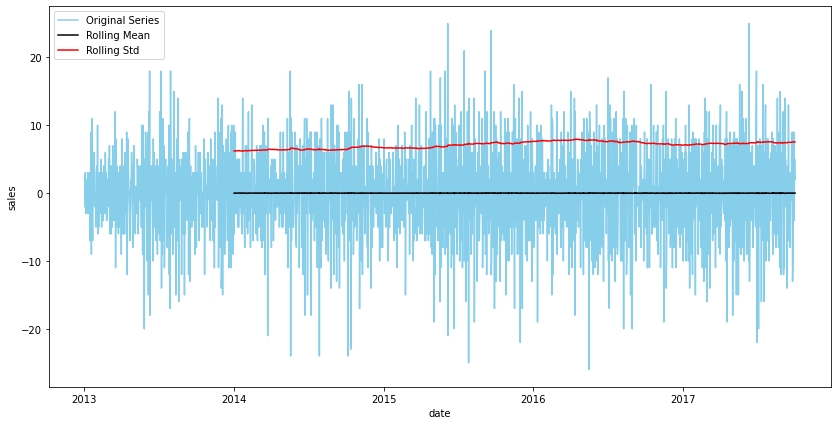

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


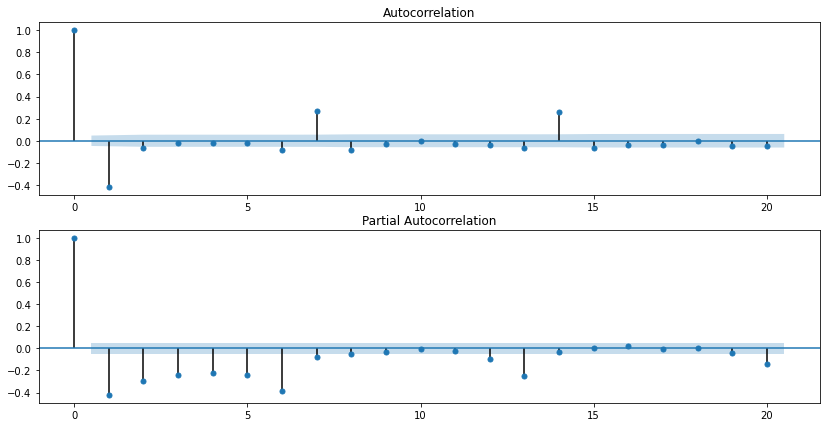

In [14]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

Data is now stationary

In [16]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5306.599
Method:                       css-mle   S.D. of innovations              5.168
Date:                Thu, 18 Mar 2021   AIC                          10631.197
Time:                        05:44:13   BIC                          10680.316
Sample:                    01-02-2013   HQIC                         10649.364
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0072      0.023      0.314      0.754      -0.038       0.052
ar.L1.D.sales    -0.6038      0.063     -9.658      0.000      -0.726      -0.481
ar.L2.D.sales    -0.6031      0.050    -

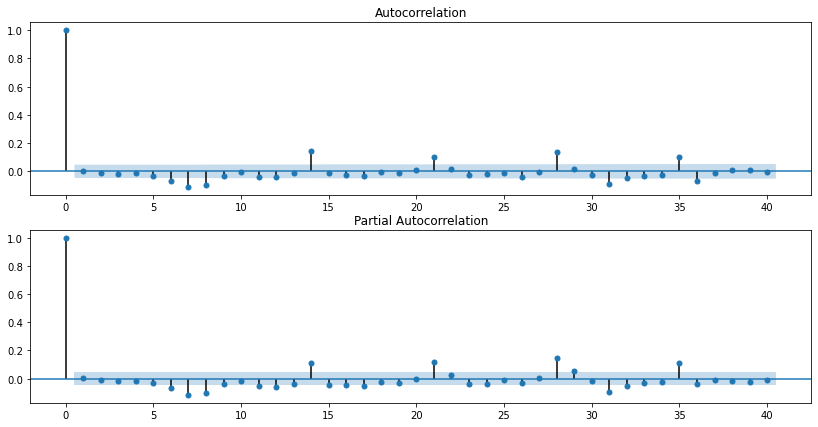

In [17]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

There is seasonality presents

C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
<ipython-input-19-d8e72ccd1ac2>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


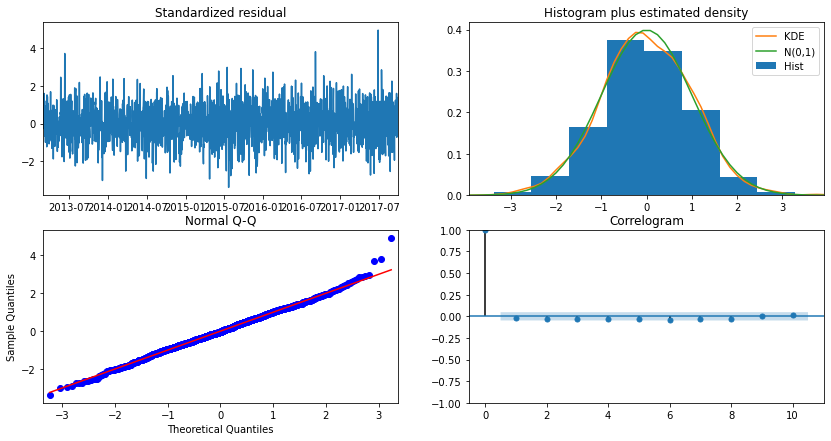

In [19]:
# fit the model - SARIMA
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot.show()

In [20]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')
arima_test_df.head()

,model,sales,pred_sales,errors
date,,,,
2017-10-01,SARIMA,21,25.926853,-4.926853
2017-10-02,SARIMA,12,15.947815,-3.947815
2017-10-03,SARIMA,18,20.717149,-2.717149
2017-10-04,SARIMA,15,21.077477,-6.077477
2017-10-05,SARIMA,20,21.303834,-1.303834


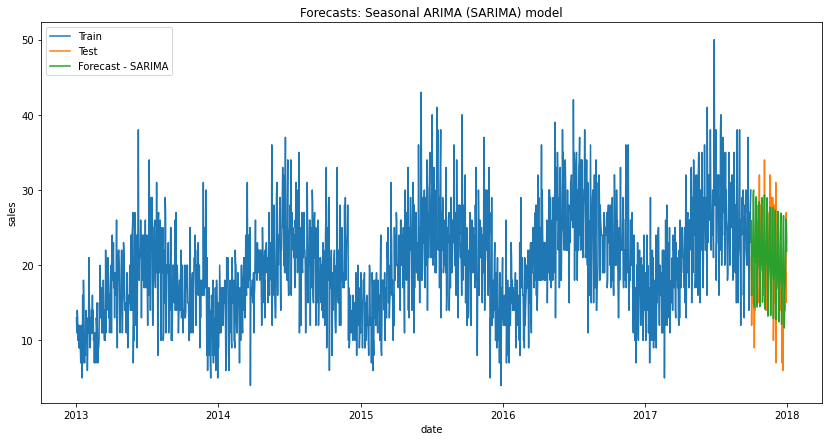

In [22]:
# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts: Seasonal ARIMA (SARIMA) model')
plt.show()

In [24]:
import numpy as np

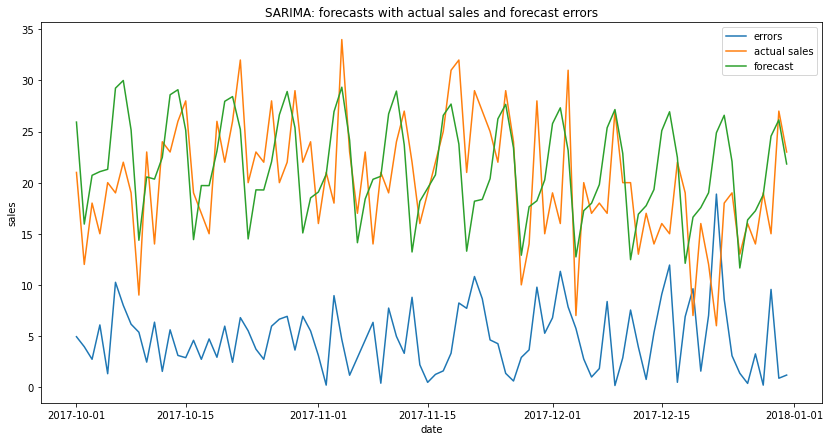

In [26]:
plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('SARIMA: forecasts with actual sales and forecast errors')
plt.show()